In [1]:
%matplotlib inline

In [2]:
# Import python modules
import numpy as np
import pandas as pd
from shapely.geometry import Point, LineString, MultiPoint, Polygon
from sklearn.gaussian_process.kernels import Matern
from shapely.wkt import loads
from scipy.spatial.ckdtree import cKDTree
import matplotlib.pyplot as plt
import netCDF4
import h5py
import gc, sys, os
sys.path.append("../scripts")
import spatial_functions
import aem_utils
import netcdf_utils
import modelling_utils
import plotting_functions as plots
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Define path to the netcdf file
infile = r"C:\Users\PCUser\Desktop\AEM\LCI\SouthernStuart_WB_MGA53.nc"

# Create an instance
lci = aem_utils.AEM_inversion(name = 'Laterally Contrained Inversion (LCI)',
                              inversion_type = 'deterministic',
                              netcdf_dataset = netCDF4.Dataset(infile))

In [ ]:
# Now we have the lines we can grid the lci conductivity data onto vertical grids (known as sections)
# this is the easiest way to visualise the AEM conuctivity in 2-dimensions

# Assign the lci variables to grid
grid_vars = ['conductivity', 'data_residual', 'depth_of_investigation']

# Define the resolution of the sections
xres, yres = 20., 4.

# We will use the lines from the rj

lines = lci.data['line'][:].astype('int')

# Get only Alice Springs lines

lines_AS = lines[lines < 101502]


# Define the output directory if saving the grids as hdf plots

hdf5_dir = r"C:\temp\SSC_hdf5"

# if the directory doesn't exist, then create it
if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)  

# Gridding takes a few minutes so I pre-gridded them for you. The lci.grid_sections()
# function below will do the gridding for you. Instead we will use the load_sectoin_from_file()
# function, which loads hdf5 files produced using the grid_sections() function


lci.grid_sections(variables = grid_vars, lines = lines_AS, xres = xres, yres = yres,
                  return_interpolated = True, save_hdf5 = True, hdf5_dir = hdf5_dir)

#lci.load_sections_from_file(hdf5_dir, grid_vars)

285738


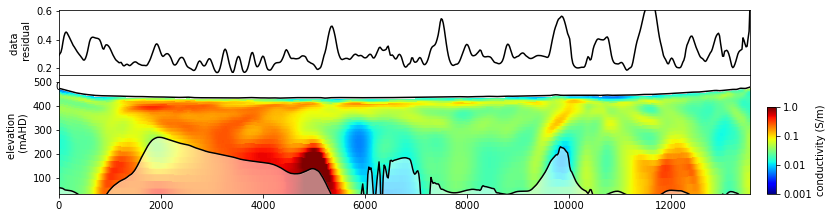

In [26]:
# Create sections

outdir = r"C:\temp\AS_sections"

if not os.path.exists(outdir):
    os.mkdir(outdir)

for line in lines_AS:
    plt.close('all')

    fig = plt.figure(figsize = (12,3))

    # Add two axes for the data misfit and the conductivity
    # 
    ax1 = fig.add_axes([0.1, 0.65, 0.8, 0.3])
    ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.55], sharex = ax1)

    # Add a color
    cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.4])

    panel_kwargs = [{'title': '',
                          'color': 'black',
                          'ylabel': 'data \n residual',
                          'legend': False,
                          },
                         {'max_depth': 400.,
                          'shade_doi': True,
                          'colourbar': True,
                          'colourbar_label': 'Conductivity (S/m)',
                          'log_plot': True,
                          'vmin': 0.001,
                          'vmax': 1.,
                          'cmap': 'jet',
                          'ylabel': 'elevation \n (mAHD)'}]

    res = plots.plot_single_line(ax1, lci.section_data[line],
                                       'data_residual', panel_kwargs[0])

    cond_section = plots.plot_grid(ax2, lci.section_data[line], 'conductivity',
                               panel_kwargs[1])

    cb = fig.colorbar(cond_section, cax=cbar_ax, orientation='vertical')

    cbar_ax.set_yticklabels([round(10 ** x, 4) for x in cb.get_ticks()])

    cb.set_label('conductivity (S/m)', fontsize=10)

    plt.savefig(os.path.join(outdir, str(line) + '.png'))


In [9]:
import importlib
importlib.reload(aem_utils)

<module 'aem_utils' from '../scripts\\aem_utils.py'>

In [3]:
# Now we will calculate the noise for the raw data and create inversion ready files

infile = r"C:\Users\PCUser\Desktop\AEM\EM\AUS_10023_SouthernStuart_EM.nc"

SSC = aem_utils.AEM_data(name = 'Southern Stuart Corridor AEM data',
                              system_name = 'SkyTEM312',
                              netcdf_dataset = netCDF4.Dataset(infile))

In [4]:
SSC.calculate_noise("low_moment_Z-component_EM_data", noise_variable = "low_moment_Z_component_noise",
                    multiplicative_noise = 0.03)

SSC.calculate_noise("high_moment_Z-component_EM_data", noise_variable = "high_moment_Z_component_noise",
                    multiplicative_noise = 0.03)

In [49]:
# Noise is root of some of the squares
lm_noise = SSC.low_moment_Z_component_noise
hm_noise = SSC.high_moment_Z_component_noise

# Now divide this by the absolute value of the data to get the relative uncertainty

lm_runc = lm_noise/np.abs(SSC.data['low_moment_Z-component_EM_data'][:].data)
hm_runc = hm_noise/np.abs(SSC.data['high_moment_Z-component_EM_data'][:].data)

In [50]:
lm_runc.shape

(622236, 18)

In [6]:
high_altitude_lines =  [x for x in SSC.data['line'][:] if x>913000]
# Get a high alitute line mask

highalt_mask = netcdf_utils.get_lookup_mask(high_altitude_lines, SSC.data)

In [7]:
d = SSC.data

In [8]:
# Now plot the runc as quantile plots


runc_quant_lm = np.nan*np.ones(shape = (10, 18), dtype = np.float32)

for j in range(18):
    runc = lm_noise[~highalt_mask,j]/np.abs(d['low_moment_Z-component_EM_data'][~highalt_mask, j])
    for i in range(runc_quant_lm.shape[0]):
        runc_quant_lm[i,j] = np.quantile(runc, 0.05 + i*0.1)
    
# high moment

runc_quant_hm = np.nan*np.ones(shape = (10, 23), dtype = np.float32)

for j in range(23):
    runc = hm_noise[~highalt_mask,j]/np.abs(d['high_moment_Z-component_EM_data'][~highalt_mask,j])
    for i in range(runc_quant_hm.shape[0]):
        runc_quant_hm[i,j] = np.quantile(runc, 0.05 + i*0.1)

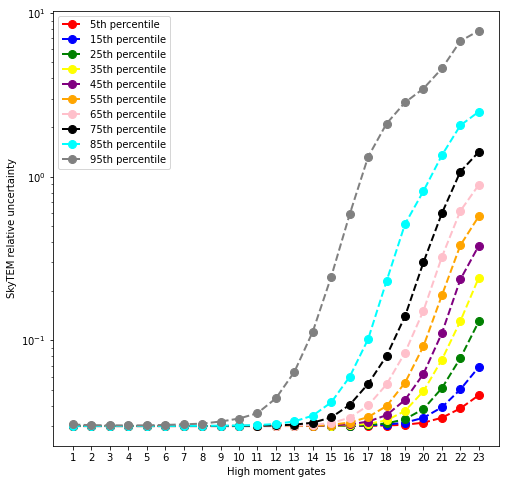

In [9]:
fig, ax= plt.subplots(1,1,figsize = (8,8))

colours = [ "red", "blue", "green", "yellow", "purple",
           "orange", "pink", "black", "aqua", 'grey']

for i in range(10):
    x = np.arange(1,24)
    ax.plot(x, runc_quant_hm[i,:],
           color=colours[i], marker='o', linestyle='dashed', 
            linewidth=2, markersize=8,
           label = str(5+(10*i)) + "th percentile")
    ax.set_yscale('log')

ax.set_xlabel("High moment gates")
ax.set_ylabel('SkyTEM relative uncertainty')
ax.set_xticks(x)
ax.legend()
#plt.savefig(r"C:\Temp\DR_hm_Ross_noise_runc_lineplot.png")
plt.show()

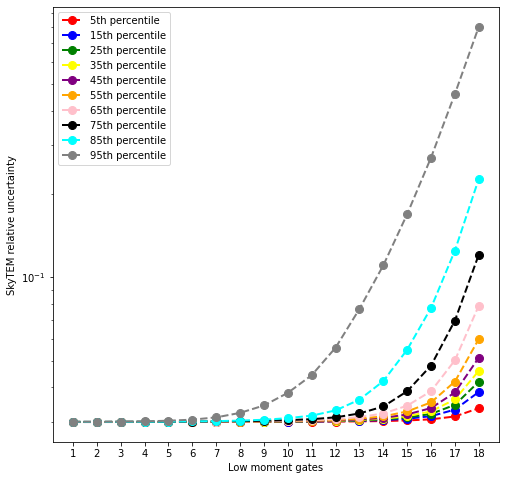

In [10]:
fig, ax= plt.subplots(1,1,figsize = (8,8))

colours = [ "red", "blue", "green", "yellow", "purple",
           "orange", "pink", "black", "aqua", 'grey']

for i in range(10):
    x = np.arange(1,19)
    ax.plot(x, runc_quant_lm[i,:],
           color=colours[i], marker='o', linestyle='dashed', 
            linewidth=2, markersize=8,
           label = str(5+(10*i)) + "th percentile")
    ax.set_yscale('log')

ax.set_xlabel("Low moment gates")
ax.set_ylabel('SkyTEM relative uncertainty')
ax.set_xticks(x)
ax.legend()
#plt.savefig(r"C:\Temp\DR_hm_Ross_noise_runc_lineplot.png")
plt.show()

In [122]:
# Get just Alice Springs lines

lines = [100101, 100201, 100301, 100401, 100501, 100601, 100701, 100801,
         100901, 101001, 101101, 101201, 101301, 101401, 101501]

line_mask = netcdf_utils.get_lookup_mask(lines, SSC.data)

# Name of output file name
outfile = r"C:\temp\AS_inversion_ready.dat"

nc_variables = ["ga_project", "utc_date", "flight", "line", "fiducial", "easting", "northing",
        "tx_height_measured", "elevation", "gps_height", "roll", "pitch", "yaw",
        "TxRx_dx", "TxRx_dy", "TxRx_dz", "low_moment_Z-component_EM_data","high_moment_Z-component_EM_data"]

nc_formats = ['{:5d}','{:9.0F}','{:12.2F}','{:8.0F}','{:12.2F}','{:10.2F}','{:11.2F}','{:8.1F}','{:9.2F}',
              '{:9.2F}','{:7.2F}','{:7.2F}','{:7.2F}','{:7.2F}','{:7.2F}','{:7.2F}', '{:15.6E}', '{:15.6E}']

other_data = {'rel_uncertainty_low_moment_Z-component': {'array': lm_runc, 'format': '{:15.6E}'},
              'rel_uncertainty_high_moment_Z-component': {'array': hm_runc, 'format': '{:15.6E}'}}

print(lm_runc.shape)
outfile = r"C:\Users\PCUser\Desktop\AEM\inversion_ready\SSC_inversion_ready.dat"

(622236, 18)


In [125]:
def write_inversion_ready_file(dataset, outpath, nc_variables,
                               nc_formats, other_variables = None,
                               mask = None):

    # Now create a mask if none exists
    if mask is None:
        mask = np.ones(shape = (dataset.dimensions['point'].size), dtype = np.bool)
    # Create an empty dataframe
    df = pd.DataFrame(index = range(mask.sum()))
    
    # Create a dictionary with arrays, formats and variable name
    data = {}
    for i, var in enumerate(nc_variables):
        if var == 'line':
            line_inds = dataset['line_index'][mask]
            arr = dataset[var][line_inds].data
        elif var == 'flight':
            flight_inds = dataset['flight_index'][mask]
            arr = dataset[var][flight_inds].data
        # Scalar variables
        elif len(dataset[var].shape) == 0:
            arr = np.repeat(dataset[var][:].data, mask.sum())
        else:
            arr = dataset[var][mask].data
        # Add to dictionary
        data[var] = {'array': arr,
                    'format': nc_formats[i]}
    # Now we add the additional columns
    if other_variables is not None:
        for item in other_variables.keys():
            # apply mask
            data[item] = {'array': other_variables[item]['array'][mask],
                          'format': other_variables[item]['format']}
    # build pandas dataframe
    for item in data:
        print(item)
        arr = data[item]['array']

        if len(arr.shape) < 2:
            df[item] = [data[item]['format'].format(x) for x in arr]
        # For 3d variables like the EM data
        else:
            for i in range(arr.shape[1]):
                df[item + '_' + str(i+1)] = [data[item]['format'].format(x) for x in arr[:,i]]
    # Note use a pipe so we can easily delete later

    df.apply(lambda row: ''.join(map(str, row)), axis=1).to_csv(outpath, sep = ',', index = False, header = False)

    # Now write the .hdr file
    header_file = '.'.join(outfile.split('.')[:-1]) + '.hdr'
    counter = 1
    with open(header_file, 'w') as f:
        for item in data.keys():
            shape = data[item]['array'].shape
            if len(shape) == 1:
                f.write(''.join([item, ' ', str(counter), '\n']))
                counter += 1
            else:
                f.write(''.join([item,' ',str(counter),'-',str(counter + shape[1] - 1),'\n']))
                counter += shape[1]
    
    
    
    

In [126]:
write_inversion_ready_file(SSC.data, outfile, nc_variables,
                               nc_formats, other_variables = other_data,
                               mask = line_mask)

ga_project
utc_date
flight
line
fiducial
easting
northing
tx_height_measured
elevation
gps_height
roll
pitch
yaw
TxRx_dx
TxRx_dy
TxRx_dz
low_moment_Z-component_EM_data
high_moment_Z-component_EM_data
rel_uncertainty_low_moment_Z-component
rel_uncertainty_high_moment_Z-component
19999
ga_project
utc_date
flight
line
fiducial
easting
northing
tx_height_measured
elevation
gps_height
roll
pitch
yaw
TxRx_dx
TxRx_dy
TxRx_dz
low_moment_Z-component_EM_data
high_moment_Z-component_EM_data
rel_uncertainty_low_moment_Z-component
rel_uncertainty_high_moment_Z-component
